In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
import time

In [157]:
bitcoin_df = pd.read_csv("../data/BitconOTC/raw/soc-sign-bitcoinotc.csv",names=['src','dest','rating','timestamp'])
bitcoin_df.head()

,src,dest,rating,timestamp
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09


## Stats of the dataset

In [158]:
print(f"Number of unique nodes:{len(pd.unique(bitcoin_df[['src', 'dest']].values.ravel()))}")
user_ids = pd.unique(bitcoin_df[['src', 'dest']].values.ravel())
id_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
bitcoin_df['src_id'] = bitcoin_df['src'].map(id_to_index)
bitcoin_df['dest_id'] = bitcoin_df['dest'].map(id_to_index)
num_nodes = len(id_to_index)

Number of unique nodes:5881


In [159]:
bitcoin_df

,src,dest,rating,timestamp,src_id,dest_id
0,6,2,4,1.289242e+09,0,1
1,6,5,2,1.289242e+09,0,2
2,1,15,1,1.289243e+09,3,4
3,4,3,7,1.289245e+09,5,6
4,13,16,8,1.289254e+09,7,8
...,...,...,...,...,...,...
35587,4499,1810,1,1.453612e+09,4378,1785
35588,2731,3901,5,1.453679e+09,2652,3798
35589,2731,4897,5,1.453679e+09,2652,4797
35590,13,1128,1,1.453680e+09,7,1081


### Normalizing the rating

In [160]:
bitcoin_df['rating'] = bitcoin_df['rating'] / 10

In [161]:
bitcoin_df

,src,dest,rating,timestamp,src_id,dest_id
0,6,2,0.4,1.289242e+09,0,1
1,6,5,0.2,1.289242e+09,0,2
2,1,15,0.1,1.289243e+09,3,4
3,4,3,0.7,1.289245e+09,5,6
4,13,16,0.8,1.289254e+09,7,8
...,...,...,...,...,...,...
35587,4499,1810,0.1,1.453612e+09,4378,1785
35588,2731,3901,0.5,1.453679e+09,2652,3798
35589,2731,4897,0.5,1.453679e+09,2652,4797
35590,13,1128,0.1,1.453680e+09,7,1081


In [162]:
incoming = bitcoin_df.groupby('dest_id').agg(
    total_in_rating=('rating', 'sum'),
    num_in_rating=('rating', 'count')
).reset_index()
incoming['avg_in_rating'] = incoming['total_in_rating'] / incoming['num_in_rating']

In [163]:
global_avg_rating = bitcoin_df['rating'].sum() / bitcoin_df['dest_id'].nunique()
print(f"global avg:{global_avg_rating}")

global avg:0.614885626493684


In [164]:
def label_user(row,fraud_threshold=0, benign_threshold = 0.2):
    if row['avg_in_rating'] < fraud_threshold:
        return 1  # fraud
    elif row['avg_in_rating'] > global_avg_rating - benign_threshold:
        return 0  # benign
    else:
        return 2  # unknown

incoming['label'] = incoming.apply(label_user, axis=1)

In [165]:
incoming

,dest_id,total_in_rating,num_in_rating,avg_in_rating,label
0,0,6.1,44,0.138636,2
1,1,12.3,41,0.300000,2
2,2,0.7,3,0.233333,2
3,3,80.1,226,0.354425,2
4,4,2.0,13,0.153846,2
...,...,...,...,...,...
5853,5875,0.1,1,0.100000,2
5854,5877,0.1,1,0.100000,2
5855,5878,0.1,1,0.100000,2
5856,5879,0.1,1,0.100000,2


In [166]:
label_series =  pd.Series(2,index=range(num_nodes))
label_series.update(incoming['label'])
y = torch.tensor(label_series.values, dtype=torch.long)
y

tensor([2, 2, 2,  ..., 2, 2, 2])

In [167]:
label_series

0       2
1       2
2       2
3       2
4       2
       ..
5876    2
5877    2
5878    2
5879    2
5880    2
Length: 5881, dtype: int64

In [168]:
incoming['label'].value_counts()

label
2    4843
1     814
0     201
Name: count, dtype: int64

In [169]:
labels = dict(zip(incoming['dest'], incoming['label']))

KeyError: 'dest'

In [170]:
print(min(bitcoin_df['timestamp']))
print(max(bitcoin_df['timestamp']))

1289241911.72836
1453684323.75728


In [171]:
bitcoin_df['datetime'] = pd.to_datetime(bitcoin_df['timestamp'],unit='s')
bitcoin_df['date'] = bitcoin_df['datetime'].dt.date
bitcoin_df['week'] = bitcoin_df['datetime'].dt.to_period('W').dt.start_time
bitcoin_df['month'] = bitcoin_df['datetime'].dt.to_period('M').dt.start_time

In [172]:
bitcoin_df

,src,dest,rating,timestamp,src_id,dest_id,datetime,date,week,month
0,6,2,0.4,1.289242e+09,0,1,2010-11-08 18:45:11.728359938,2010-11-08,2010-11-08,2010-11-01
1,6,5,0.2,1.289242e+09,0,2,2010-11-08 18:45:41.533780098,2010-11-08,2010-11-08,2010-11-01
2,1,15,0.1,1.289243e+09,3,4,2010-11-08 19:05:40.390490055,2010-11-08,2010-11-08,2010-11-01
3,4,3,0.7,1.289245e+09,5,6,2010-11-08 19:41:17.369750023,2010-11-08,2010-11-08,2010-11-01
4,13,16,0.8,1.289254e+09,7,8,2010-11-08 22:10:54.447459936,2010-11-08,2010-11-08,2010-11-01
...,...,...,...,...,...,...,...,...,...,...
35587,4499,1810,0.1,1.453612e+09,4378,1785,2016-01-24 05:14:41.647289991,2016-01-24,2016-01-18,2016-01-01
35588,2731,3901,0.5,1.453679e+09,2652,3798,2016-01-24 23:50:28.049489975,2016-01-24,2016-01-18,2016-01-01
35589,2731,4897,0.5,1.453679e+09,2652,4797,2016-01-24 23:50:34.034019947,2016-01-24,2016-01-18,2016-01-01
35590,13,1128,0.1,1.453680e+09,7,1081,2016-01-24 23:53:52.985709906,2016-01-24,2016-01-18,2016-01-01


Text(0.5, 1.0, 'weekly_counts')

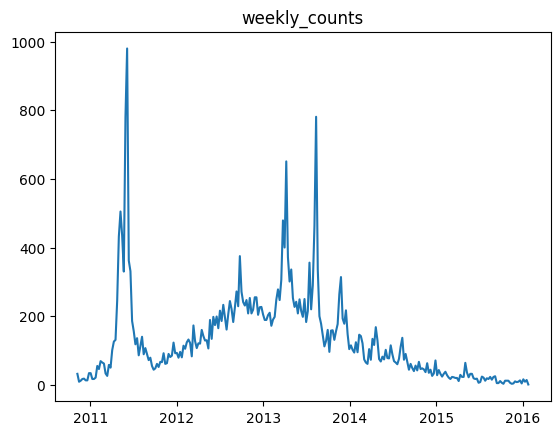

In [173]:
plt.plot(bitcoin_df.groupby('week').size())
plt.title("weekly_counts")

In [174]:
data_list = []
for week, group in bitcoin_df.groupby('week'):
    edge_index = torch.tensor([group['src_id'].values, group['dest_id'].values], dtype=torch.long)
    edge_attr = torch.tensor(group['rating'].values, dtype=torch.float).unsqueeze(1)
    x = torch.ones((num_nodes, 1), dtype=torch.float)
    active_nodes = torch.unique(edge_index.flatten())
    node_mask = torch.zeros(num_nodes, dtype=torch.bool)
    node_mask[active_nodes] = True
    data = Data()
    data.x = x
    data.y = y
    data.edge_index = edge_index
    data.edge_attr = edge_attr
    data.num_nodes = len(active_nodes)
    data.node_mask = node_mask
    data_list.append(data)
    print(data)

Data(x=[5881, 1], y=[5881], edge_index=[2, 32], edge_attr=[32, 1], num_nodes=18, node_mask=[5881])
Data(x=[5881, 1], y=[5881], edge_index=[2, 9], edge_attr=[9, 1], num_nodes=9, node_mask=[5881])
Data(x=[5881, 1], y=[5881], edge_index=[2, 12], edge_attr=[12, 1], num_nodes=7, node_mask=[5881])
Data(x=[5881, 1], y=[5881], edge_index=[2, 17], edge_attr=[17, 1], num_nodes=15, node_mask=[5881])
Data(x=[5881, 1], y=[5881], edge_index=[2, 18], edge_attr=[18, 1], num_nodes=16, node_mask=[5881])
Data(x=[5881, 1], y=[5881], edge_index=[2, 13], edge_attr=[13, 1], num_nodes=10, node_mask=[5881])
Data(x=[5881, 1], y=[5881], edge_index=[2, 13], edge_attr=[13, 1], num_nodes=12, node_mask=[5881])
Data(x=[5881, 1], y=[5881], edge_index=[2, 34], edge_attr=[34, 1], num_nodes=26, node_mask=[5881])
Data(x=[5881, 1], y=[5881], edge_index=[2, 34], edge_attr=[34, 1], num_nodes=22, node_mask=[5881])
Data(x=[5881, 1], y=[5881], edge_index=[2, 17], edge_attr=[17, 1], num_nodes=15, node_mask=[5881])
Data(x=[5881, 